In [1]:
%matplotlib nbagg
%load_ext pyopencl.ipython_ext

In [2]:
import os
import numpy
from matplotlib.pyplot import subplots
import glob
import fabio
import h5py
import hdf5plugin
import pyopencl as cl
from pyopencl import array as cla
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [3]:
os.environ["PYOPENCL_CTX"]="0:0"
frames = glob.glob('/mnt/data/ID10/CDI/SiO2msgel3_cand1/img_*.edf')
nframes = len(frames)
shape = 568, 568
volume = (568, 568, 568)
center = (284, 284)
pixel_size = numpy.float32(55e-6)
distance = numpy.float32(3.3)
dummy = numpy.float32(0.0)
print("Processing ",nframes, "frames")

Processing  811 frames


In [4]:
ctx = cl.create_some_context(interactive=False)
queue = cl.CommandQueue(ctx)
ctx

<pyopencl.Context at 0x237d030 on <pyopencl.Device 'GeForce GT 1030' on 'NVIDIA CUDA' at 0x19b8eb0>>

In [5]:
%%cl_kernel 


// Function to perform an atom addition in global memory (does not exist in OpenCL)
inline void atomic_add_global_float(volatile global float *addr, float val)
{
   union {
       uint  u32;
       float f32;
   } next, expected, current;
   current.f32    = *addr;
   do {
       expected.f32 = current.f32;
       next.f32     = expected.f32 + val;
       current.u32  = atomic_cmpxchg( (volatile global uint *)addr,
                                      expected.u32, next.u32);
   } while( current.u32 != expected.u32 );
}

// Performs the centering/scaling in the detector plane. Image flipping must be implemented here
float2 inline calc_position_real(float2 index,
                                 float2 center,
                                 float pixel_size)
{
    return (index - center) * pixel_size;
}

// Transforms a 2D position in the image into a 3D coordinate in the volume
float3 inline calc_position_rec(float2 index,
                                float2 center,
                                float pixel_size,
                                float distance,
                                float3 Rx,
                                float3 Ry,
                                float3 Rz)
{
    float2 pos2 = calc_position_real(index, center, pixel_size);
    float d = sqrt(distance*distance + dot(pos2, pos2));
    float3 pos3 = (float3)(pos2.x/d, pos2.y/d, distance/d-1.0f);
    float scale = distance*distance/pixel_size;
    return scale * (float3)(dot(Rx, pos3), dot(Ry, pos3), dot(Rz, pos3));
}

//Storage for that many voxel per pixel
#define STORAGE_SIZE 64

kernel void regid_CDI(global float* image,
                      const  int    height,
                      const  int    width,
                      const  float  dummy,
                      const  float  pixel_size,
                      const  float  distance,
                      const  float  phi,
                      const  float  center_x,
                      const  float  center_y,
                      global float* signal,
                      global int*   norm,
                      const  int    shape,
                      int    oversampling)
{
    int tmp, shape_2, i, j, k;
    size_t where_in, where_out;
    float value, delta;
    float2 pos2, center = (float2)(center_x, center_y);
    float3 Rx, Ry, Rz, recip;
    
    //This is local storage of voxels to be written
    int last=0;
    size_t index[STORAGE_SIZE];
    float2 store[STORAGE_SIZE];
    
    
    
    if ((get_global_id(0)>=height) || (get_global_id(1)>=width))
        return;
    
    where_in = width*get_global_id(0)+get_global_id(1);
    shape_2 = shape/2;
    oversampling = (oversampling<1?1:oversampling);
    delta = 1.0f / oversampling;
    {   
        float cos_phi, sin_phi;
        cos_phi = cos(phi*M_PI_F/180.0f);
        sin_phi = sin(phi*M_PI_F/180.0f);
        Rx = (float3)(cos_phi, 0.0f, sin_phi);
        Ry = (float3)(0.0f, 1.0f, 0.0f);
        Rz = (float3)(-sin_phi, 0.0f, cos_phi);
        
    }
    
    // No oversampling for now
    //this is the center of the pixel
    //pos2 = (float2)(get_global_id(1)+0.5f, get_global_id(0) + 0.5f); 
    
    
    value = image[where_in];
    
    //dynamic masking
    if (value == dummy) return;
    
    //Basic oversampling    
    for (i=0; i<oversampling; i++)
    {
        for (j=0; j<oversampling; j++)
        {
            pos2 = (float2)(get_global_id(1) + (i + 0.5f)*delta, 
                            get_global_id(0) + (j + 0.5f)*delta); 
            recip = calc_position_rec(pos2, center, pixel_size, distance, Rx, Ry, Rz);
            
    
            tmp = (int)recip.x + shape/2;
            if ((tmp>=0) && (tmp<shape))
            {
                where_out = tmp;
                tmp = (int)recip.y + shape_2;
                if ((tmp>=0) && (tmp<shape))
                {
                    where_out += tmp * shape;
                    tmp = (int)recip.z + shape_2;
                    if ((tmp>=0) && (tmp<shape))
                    {
                        where_out += ((long)tmp) * shape * shape;                          
                        signal[where_out] += value;
                        norm[where_out] += 1.0f;
                        
                        //storage locally
                        int found = 0;
                        for (k=0; k<last; k++)
                        {
                            if (where_out == index[k])
                            {
                                    store[k] += (float2)(value, 1.0f);
                                    found = 1;
                                    k = last;
                            }
                        }
                        if (found == 0)
                        {
                            if (last >= STORAGE_SIZE)
                                printf("Too many voxels covered by pixel\n");
                            else
                            {
                                index[last] = where_out;
                                store[last] = (float2)(value, 1.0f);
                                last++;
                            }
                        }  
                    }
                }               
            }            
        }
    }
    // Finally we update the global memory with atomic writes
    for (k=0; k<last; k++)
    {
        atomic_add_global_float(&signal[index[k]], store[k].s0);
        atomic_add(&norm[index[k]], (int)store[k].s1);
    }
}


In [6]:
image_d = cla.empty(queue, shape, dtype=numpy.float32)
signal_d = cla.empty(queue, volume, dtype=numpy.float32)
norm_d = cla.empty(queue, volume, dtype=numpy.int32)
ws = (8,4)

In [7]:
def meas_phi(f):
    return numpy.float32(f.header.get("motor_pos").split()[f.header.get("motor_mne").split().index("ths")])
meas_phi(fabio.open(frames[51]))

-44.6

In [8]:
%%time
oversampling = numpy.int32(8)
signal_d.fill(0.0)
norm_d.fill(0)
_center = numpy.float32(center[0]),numpy.float32(center[1])
_shape = numpy.int32(shape[1]),numpy.int32(shape[0])
_volume_shape = numpy.int32(volume[0])
ldphi = numpy.linspace(0, 0.2, oversampling//2,endpoint=False,dtype=numpy.float32)
for i in frames:
    f = fabio.open(i)
    image_d.set(f.data)
    phi = meas_phi(f)
    for dphi in ldphi:
        evt = regid_CDI(queue, shape, ws,
                                image_d.data,
                                *_shape,
                                dummy,
                                pixel_size,
                                distance,
                                phi+dphi,
                                *_center,
                                signal_d.data,
                                norm_d.data,
                                _volume_shape,
                                oversampling)
evt.wait()

CPU times: user 1min 32s, sys: 33.5 s, total: 2min 6s
Wall time: 2min 7s


In [21]:
#norm_d.get().max()
ldphi

array([0.  , 0.05, 0.1 , 0.15], dtype=float32)

In [10]:
#Not enough memory on GPU
volume_h=signal_d.get()/norm_d.get()
volume_h[numpy.isfinite(volume_h)].min()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


-39933.2625

<IPython.core.display.Javascript object>


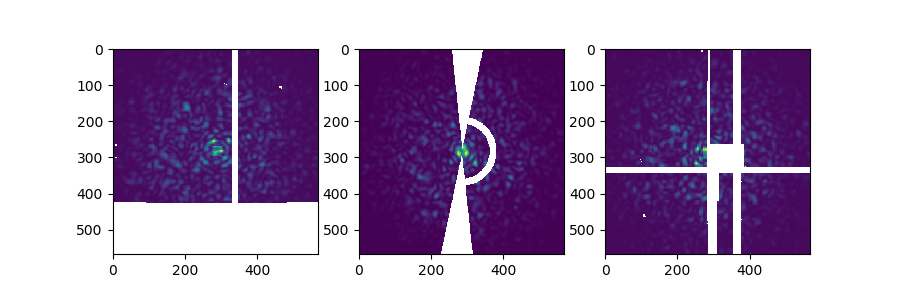

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


In [11]:
fig, ax = subplots(1, 3, figsize=(9,3))
x=y=z=255
i0=ax[0].imshow(volume_h[:,:,x])
i1=ax[1].imshow(volume_h[:,y,:])
i2=ax[2].imshow(volume_h[z,:,:])
x = widgets.IntSlider(x, 0,volume[2]-1)
y = widgets.IntSlider(y, 0,volume[1]-1)
z = widgets.IntSlider(z, 0,volume[0]-1)
ui = widgets.HBox([x, y, z])
def update(x, y, z):
    i0.set_data(volume_h[:,:,x])
    i1.set_data(volume_h[:,y,:])
    i2.set_data(volume_h[z,:,:])
    fig.canvas.draw()
    fig.canvas.flush_events()

out = widgets.interactive_output(update, {'x': x, 'y': y, 'z': z})

display(ui, out)

In [12]:
signal_d.get().mean(), norm_d.get().mean()

(30424.105, 66.97335278860352)

In [20]:
with h5py.File("regrid.h5", mode="w") as h:
    h.create_dataset("SiO2msgel3", data=volume_h, **hdf5plugin.Bitshuffle())

In [14]:
%%cl_kernel 

// Function to perform an atom addition in global memory (does not exist in OpenCL)
inline void atomic_add_global_float(volatile global float *addr, float val)
{
   union {
       uint  u32;
       float f32;
   } next, expected, current;
   current.f32    = *addr;
   do {
       expected.f32 = current.f32;
       next.f32     = expected.f32 + val;
       current.u32  = atomic_cmpxchg( (volatile global uint *)addr,
                                      expected.u32, next.u32);
   } while( current.u32 != expected.u32 );
}

// Performs the centering/scaling in the detector plane. Image flipping must be implemented here
float2 inline calc_position_real(float2 index,
                                 float2 center,
                                 float pixel_size)
{
    return (index - center) * pixel_size;
}

// Transforms a 2D position in the image into a 3D coordinate in the volume
float3 inline calc_position_rec(float2 index,
                                float2 center,
                                float pixel_size,
                                float distance,
                                float3 Rx,
                                float3 Ry,
                                float3 Rz)
{
    float2 pos2 = calc_position_real(index, center, pixel_size);
    float d = sqrt(distance*distance + dot(pos2, pos2));
    float3 pos3 = (float3)(pos2.x/d, pos2.y/d, distance/d-1.0f);
    float scale = distance*distance/pixel_size;
    return scale * (float3)(dot(Rx, pos3), dot(Ry, pos3), dot(Rz, pos3));
}


//Perform a bilinear interpolation of image with 3 channels
static float3 bilinear3(float2 target,       //expected coordinated
                        local float3* patch, //patch, section of the image in shared memory
                        int2 size,           //size of the patch 
                        int mode) //mode = 1 bilinear or 0 for nearest
{
    int tx_prev = (int) target.x,
        tx_next = tx_prev + 1,
        ty_prev = (int) target.y,
        ty_next = ty_prev + 1;

    float3 interp;

    if (0.0f <= target.x && target.x < (size.x - 1) && 0.0f <= target.y && target.y < (size.y - 1) )
    {
        if (mode == 0) 
        {   
            //nearest neighbour interpolation
            interp = patch[(int)(target.y + 0.5) * size.x + (int)(target.x + 0.5)];
        }
        else
        {   //bilinear interpolation: read 4 neighbours
            float3 image_p = patch[ ty_prev*size.x + tx_prev],
                   image_x = patch[ ty_prev*size.x + tx_next],
                   image_y = patch[ ty_next*size.x + tx_prev],
                   image_n = patch[ ty_next*size.x + tx_next];

             // this guard should not be needed
            if (tx_next >= size.x) 
            {
                image_x = image_p;
                image_n = image_y;
            }
            if (ty_next >= size.y) {
                image_y = image_p;
                image_n = image_x;
            }

            //bilinear interpolation
            float3 interp1 = (tx_next - target.x) * image_p + (target.x - tx_prev) * image_x,
                   interp2 = (tx_next - target.x) * image_y + (target.x - tx_prev) * image_n;

            interp = (ty_next - target.y) * interp1 + (target.y - ty_prev) * interp2;

        }
    }
    
    return interp;
}

/* Performs the regridding of an image on a 3D volume
 *
 * 2D kernel, one thread per input pixel. Scatter-like kernel with atomics.
 * 
 * pixel start at 0 and finish at 1, the center is at 0.5
 * thread ids follow the memory location convention (zyx) not the math x,y,z convention 
 *   
 * Collborative calculation of the 3D position of the kernel (shared memory)
 * Linear interpolation within every pixel from the corner coordinates
 * 
 * Needs in shared memory: (wg0+1)*(wg1+1)*4*4  = 17424 for a 32x32 kernel
 */ 


kernel void regid_CDI_shared(global float* image,
                             const  int height,
                             const  int width,
                             const  float pixel_size,
                             const  float distance,
                             const  float phi,
                             const  float center_x,
                             const  float center_y,
                             global float *signal,
                             global float *norm,
                             const  int shape,
                                    int oversampling,
                             local float3* corners)
{
    int tmp, shape_2, i, j, tid;
    size_t where_in, where_out;
    float value, cos_phi, sin_phi, delta, start;
    float2 pos2, center = (float2)(center_x, center_y);
    float3 Rx, Ry, Rz, recip, A, B, C, D;
    int2 shared_shape = (int2)(1 + get_local_size(0), 1 + get_local_size(1));
    
    where_in = width*get_global_id(0)+get_global_id(1);
    shape_2 = shape/2;
    oversampling = (oversampling<1?1:oversampling);
    start = 0.5f / oversampling;
    delta = 2 * start;
    
    cos_phi = cos(phi*M_PI_F/180.0f);
    sin_phi = sin(phi*M_PI_F/180.0f);
    Rx = (float3)(cos_phi, 0.0f, sin_phi);
    Ry = (float3)(0.0f, 1.0f, 0.0f);
    Rz = (float3)(-sin_phi, 0.0f, cos_phi);

    //Populate the shared memory
    {
        int tid = get_local_size(1)*get_global_id(0)+get_global_id(1);
        int ws = get_local_size(1)*get_local_size(0);
        int shared_size = shared_shape.s0*shared_shape.s1;
        for (i=0; i<shared_size; i+=ws)
        {
            int x, y, idx;
            idx = i+tid;
            if (idx<shared_size)
            {
                x = get_local_size(1)*get_group_id(1) + idx%shared_shape.s1;
                y = get_local_size(0)*get_group_id(0) + idx/shared_shape.s1;
                corners[i] = calc_position_rec((float2)(x,y), center, pixel_size, distance, Rx, Ry, Rz);
            }
        }
        barrier(CLK_LOCAL_MEM_FENCE);
    }
    
    // No processing for invalide pixels
    if ((get_global_id(0)>=height) || (get_global_id(1)>=width))
        return;

    //manage masked/invalid pixels here
    value = image[where_in];
    if (!isfinite(value))
        return;
    
    //Basic oversampling    
    for (i=0; i<oversampling; i++)
    {
        for (j=0; j<oversampling; j++)
        {
            // bilinear interpolation ...
            float2 target = (float2)(start + get_local_id(0) + i*delta,
                                     start + get_local_id(1) + j*delta);
            recip = bilinear3(target,      //expected coordinated
                              corners,     //section of the image in shared memory
                              shared_shape,//size of the shared memory 
                              1);           //mode = 1 bilinear or 0 for nearest            
    
            tmp = (int)recip.x + shape/2;
            if ((tmp>=0) && (tmp<shape))
            {
                where_out = tmp;
                tmp = (int)recip.y + shape_2;
                if ((tmp>=0) && (tmp<shape))
                {
                    where_out += tmp * shape;
                    tmp = (int)recip.z + shape_2;
                    if ((tmp>=0) && (tmp<shape))
                    {
                        where_out += ((long)tmp) * shape * shape;  
                        atomic_add_global_float(&signal[where_out], value);
                        atomic_add_global_float(&norm[where_out], 1.0f);
                        
                        //signal[where_out] += value;
                        //norm[where_out] += 1.0f;
                    }
                }               
            }            
        }
    }
}